In [1]:
# Объединение данных JPG & TIF (2017-07-03)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [7]:
binsData = 96

trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
if False : # True :
    trDirI = trDirJPG
    teDirI = teDirJPG
    ttExt  = '.jpg'
else :
    trDirI = trDirTIF
    teDirI = teDirTIF
    ttExt  = '.tif'
trWork, teWork = '../Work/Train', '../Work/Test'
print (trDirI,teDirI, trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Data/train-tif-v2 ../Data/test-tif-v2 ../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [8]:
binsDataTIF = 256
binsDataJPG = 256

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
#labels_df.head()

In [15]:
# Данные для объединения от jpg
##binsDataJPG2 = 64
trX_TIF  = np.load('../Work/t-'+str(10000+binsDataTIF)+'.tif'+'-XX-train.npy')
trX_JPG  = np.load('../Work/t-'+str(10000+binsDataJPG)+'.jpg'+'-XX-train.npy')
##trX_JPG2 = np.load('../Work/train-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
trY      = np.load('../Work/t-'+str(10000+binsDataJPG)+'.jpg'+'-YY-train.npy')
trX_TIF.shape, trX_JPG.shape

((40479, 1536), (40479, 768))

In [20]:
## Обрезка видимой части и использование только n, nvi, dwi
##trX_TIF = trX_TIF[:,288:]

In [21]:
##trX_TIF.shape, 290/3

In [17]:
##trXX = np.hstack([trX_JPG,trX_JPG2,trX_TIF])
trXX = np.hstack([trX_JPG,trX_TIF])
trX  = trXX
print (trX.shape,trX_TIF.shape,trX_JPG.shape,trY.shape)
##del trXX,trX_JPG,trX_TIF,trX_JPG2
del trXX,trX_JPG,trX_TIF

(40479, 2304) (40479, 1536) (40479, 768) (40479, 17)


In [19]:
6*256+3*256

2304

In [20]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

In [21]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [22]:
# Процедуры для оценки результативности

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [23]:
# Построение пределов прохождения для предсказанного
def getTh (tGround,tPredict, prec=100 ) :
    ixx,iacc = [], []
    for i in range(tGround.shape[1]) :
        max, maxxx = 0.0, 0.0
        for xx in range(0,prec+1) :
            tempYP = getProb01(tPredict[:,i],th=(float(xx)/prec)); #print(tPredict[:,1],tempYP[0])
            temp = skm.accuracy_score(tGround[:,i],tempYP)
            #print(float(xx/10.0),temp)
            if (temp>max) : 
                max = temp; maxxx = float(xx)
                temp = skm.confusion_matrix(tGround[:,i],tempYP);
                minloss = temp[0][1]+temp[1][0]
        ixx.append(maxxx)
        tempYP = getProb01 (tPredict[:,i])
        temp = skm.accuracy_score(tGround[:,i],tempYP)
        minloss05 = skm.confusion_matrix(tGround[:,i],tempYP);
        minloss05 = minloss05[0][1]+minloss05[1][0]
        iacc.append((maxxx,max,temp,minloss,minloss05))
    ixx = [float(xx/prec) for xx in ixx]
    return (ixx,iacc)

In [24]:
# Оценка нескольких наборов
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

def estimateTrain (estimateList, param) :
    res = []
    for jpgtif, bins in estimateList :
        trX     = np.load('../Work/train-data-XX'+str(bins)+jpgtif+'.npy')
        trY     = np.load('../Work/train-data-YY'+str(bins)+jpgtif+'.npy')
        listBST = getListBST(param, trX, trY)
        trYP    = buildPredictX(trX,listBST)
        trYY    = getProb01(trYP)
        res.append(np.array(getConfusion(trY,trYY)))
    return(res)      

In [26]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [27]:
# Считаем
print(datetime.datetime.now(),'Begin')
bstList = getListBST(param,trX,trY)
print(datetime.datetime.now(),'End')

2017-07-04 02:14:03.166250 Begin
Working: 0
[0]	train-auc:0.94385+0.00523594	test-auc:0.928177+0.00436069
[30]	train-auc:0.992606+0.000297003	test-auc:0.962953+0.000929039
[0]	train-auc:0.942882	train-rmse:0.377319
[1]	train-auc:0.950998	train-rmse:0.299325
[2]	train-auc:0.954156	train-rmse:0.249311
[3]	train-auc:0.957983	train-rmse:0.217567
[4]	train-auc:0.964084	train-rmse:0.197926
[5]	train-auc:0.969259	train-rmse:0.184598
[6]	train-auc:0.97096	train-rmse:0.176938
[7]	train-auc:0.973706	train-rmse:0.172035
[8]	train-auc:0.975542	train-rmse:0.168706
[9]	train-auc:0.976969	train-rmse:0.166188
[10]	train-auc:0.977974	train-rmse:0.164635
[11]	train-auc:0.979466	train-rmse:0.162311
[12]	train-auc:0.980417	train-rmse:0.160466
[13]	train-auc:0.981341	train-rmse:0.15926
[14]	train-auc:0.982336	train-rmse:0.157637
[15]	train-auc:0.983527	train-rmse:0.156278
[16]	train-auc:0.984423	train-rmse:0.154727
[17]	train-auc:0.98483	train-rmse:0.153975
[18]	train-auc:0.985461	train-rmse:0.152555
[19]	

In [28]:
# Шаблоны имен файллов для сохранения моделей xgb
fModel1 = '../Work/Models/model-'
fModel2 = '-jpg-'+str(binsDataJPG)+'--tif-'+str(binsDataTIF)+'.xgb'

In [29]:
# save xgb models into files
for i in range(len(bstList)) :
    ##bstList[i].save_model(fModel1+str(100+i)+'-JPG2'+fModel2)
    bstList[i].save_model(fModel1+str(100+i)+fModel2)

In [615]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
bstList = bstList0
del bstList0
len(bstList)

17

In [30]:
trYP  = buildPredict(dtrain,bstList)
trYPP = trYP.copy() # вероятностный массив
trYP  = getProb01(trYP)
print (trYP.shape, '\n', trYPP[0], '\n', trYP[0])

(40479, 17) 
 [  7.93093860e-01   9.98456836e-01   4.04365454e-03   4.96342368e-02
   1.53309600e-02   1.86946813e-03   5.23765665e-03   2.70489370e-03
   3.18855338e-04   1.37488954e-04   1.92369233e-04   3.39003818e-05
   6.39031816e-04   4.82440441e-07   1.06160529e-03   7.83072726e-04
   2.92365410e-04] 
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [31]:
#accListOld = accList

In [32]:
# Оценка точности предсказания по train массиву по разным методикам
accList = []
for i in range(trYP.shape[1]) :
    print ('#{} accuracy={} precision={} recall={} ros_auc={} fbeta2={} not={}'.format(i, 
                                           skm.accuracy_score(trY[:,i],trYP[:,i]), 
                                           skm.precision_score(trY[:,i],trYP[:,i]), 
                                           skm.recall_score(trY[:,i],trYP[:,i]), 
                                           skm.roc_auc_score(trY[:,i],trYP[:,i]), 
                                           skm.fbeta_score(trY[:,i],trYP[:,i],beta=2),
                                           len(trYP[trYP[:,i]<>trY[:,i],i])))
    accList.append((i, skm.roc_auc_score(trY[:,i],trYP[:,i]), skm.confusion_matrix(trY[:,i],trYP[:,i])))
    #fpr,tpr,thr = skm.roc_curve(trY[:,i],trYP[:,i]); print (len(thr),len(fpr),len(trYP[:,i]))
    #plt.plot(fpr,tpr); plt.show()

#0 accuracy=0.974159440698 precision=0.866075388027 recall=0.724137931034 ros_auc=0.858072353374 fbeta2=0.748677451507 not=1046
#1 accuracy=0.996541416537 precision=0.997153271078 recall=0.999120304961 ros_auc=0.981522391186 fbeta2=0.998726277586 not=140
#2 accuracy=0.939672422738 precision=0.924718231094 recall=0.87275680065 ros_auc=0.92084438527 fbeta2=0.882676609234 not=2442
#3 accuracy=1.0 precision=1.0 recall=1.0 ros_auc=1.0 fbeta2=1.0 not=0
#4 accuracy=0.936090318437 precision=0.91933240612 recall=0.713533936041 ros_auc=0.849751121885 fbeta2=0.746977059555 not=2587
#5 accuracy=0.966402332073 precision=0.918790968682 recall=0.689344262295 ros_auc=0.841643803382 fbeta2=0.72558380306 not=1360
#6 accuracy=0.928407322315 precision=0.870930732827 recall=0.752447032586 ros_auc=0.862338055913 fbeta2=0.773492625519 not=2898
#7 accuracy=0.941278193631 precision=0.904468412943 recall=0.52445834264 ros_auc=0.758784918223 fbeta2=0.572571205618 not=2377
#8 accuracy=0.997900145755 precision=1.0

In [33]:
# сравнение текущего и предыдущего результата если есть
#if accListOld is not None :
[(i,cm[0,1]+cm[1,0],(accList[i][2][1,0]+accListOld[i][2][0,1]),
  cm[0,1]+cm[1,0]-(accList[i][2][1,0]+accListOld[i][2][0,1])) for i,roc,cm in accList]

NameError: name 'accListOld' is not defined

In [34]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-498)/40497.0, (40497.0-898)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((82, 17), [3, 10, 0, 9], 0.9877027927994666, 0.9778255179396005)

In [35]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

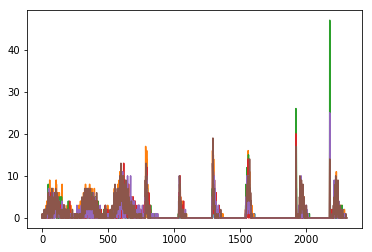

['haze', 'agriculture', 'water', 'habitation', 'road', 'cultivation']

In [37]:
xx = [0,2,4,5,6,7] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


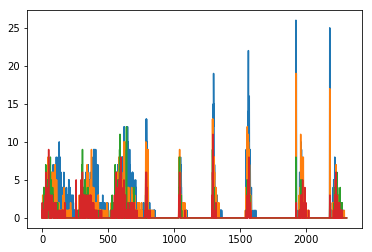

['primary', 'bare_ground', 'blooming', 'selective_logging']

In [38]:
xx = [1,12,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


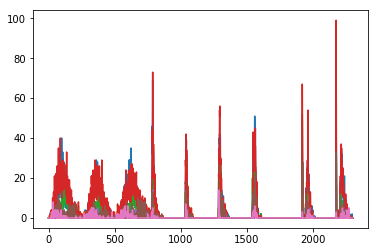

['clear',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'artisinal_mine',
 'blow_down']

In [40]:
xx = [3,8,9,10,11,13,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [41]:
# Посчитать уровень прохождения для каждого признака
ixx, iacc = getTh(trY,trYPP)
np.array(ixx), iacc

(array([ 0.41,  0.55,  0.44,  0.5 ,  0.39,  0.38,  0.42,  0.35,  0.19,
         0.24,  0.07,  0.09,  0.25,  0.03,  0.19,  0.2 ,  0.2 ]),
 [(41.0, 0.97554287408285778, 0.97415944069764571, 990, 1046),
  (55.0, 0.99730724573235507, 0.99654141653696982, 109, 140),
  (44.0, 0.94201931865905775, 0.9396724227377159, 2347, 2442),
  (50.0, 1.0, 1.0, 0, 0),
  (39.0, 0.94046295610069419, 0.9360903184367203, 2410, 2587),
  (38.0, 0.97124434892166311, 0.96640233207342074, 1164, 1360),
  (42.0, 0.93097655574495419, 0.92840732231527456, 2794, 2898),
  (35.0, 0.95321030657871986, 0.94127819363126564, 1894, 2377),
  (19.0, 0.99945650831295241, 0.99790014575458885, 22, 85),
  (24.0, 1.0, 1.0, 0, 0),
  (7.0, 1.0, 1.0, 0, 0),
  (9.0, 1.0, 1.0, 0, 0),
  (25.0, 0.99743076657032037, 0.9943427456211863, 104, 229),
  (3.0, 1.0, 1.0, 0, 0),
  (19.0, 0.9972084290619827, 0.99463919563230319, 113, 217),
  (20.0, 0.99706020405642437, 0.9943427456211863, 119, 229),
  (20.0, 1.0, 0.99977766249166233, 0, 9)])

In [42]:
# Forming output dataset for predicting --> trOX, trOY
#del(trX)
#del(trY)

In [44]:
# Данные для объединения от jpg
##trOX_JPG1 = np.load('../Work/test-data-XX'+str(binsDataJPG)+'.jpg'+'.npy')
##trOX_JPG2 = np.load('../Work/test-data-XX'+str(binsDataJPG2)+'.jpg'+'.npy')
#trOY_JPG1 = np.load('../Work/test-data-YY'+str(binsDataJPG)+'.jpg'+'.npy')
#trOY_JPG2 = np.load('../Work/test-data-YY'+str(binsDataJPG2)+'.jpg'+'.npy')
trOX_JPG  = np.load('../Work/t-'+str(10000+binsDataJPG)+'.jpg'+'-XX-test.npy')
trOX_TIF  = np.load('../Work/t-'+str(10000+binsDataTIF)+'.tif'+'-XX-test.npy')
trOY_TIF  = np.load('../Work/t-'+str(10000+binsDataTIF)+'.tif'+'-YY-test.npy')
trOY_JPG  = np.load('../Work/t-'+str(10000+binsDataJPG)+'.jpg'+'-YY-test.npy')

In [51]:
#trOX_TIF.shape, trOX_JPG.shape, trOX_JPG2.shape , 578+255+192
trOX_TIF.shape, trOX_JPG.shape , (1536+768)/256, (1536+768)

((61191, 1536), (61191, 768), 9, 2304)

In [49]:
# Обрезка видимой части и использование только n, nvi, dwi
##trOX_TIF = trOX_TIF[:,288:]
##trOX_TIF.shape

In [50]:
# Аккуратно объединяем через индексы = имена файлов
##dfOX_JPG1 = pd.DataFrame(trOX_JPG,index=trOY_JPG1)
##dfOX_JPG2 = pd.DataFrame(trOX_JPG2,index=trOY_JPG2)
##dfOX_JPG  = dfOX_JPG1.join(dfOX_JPG2,lsuffix='_l',rsuffix='_r')

dfOX_TIF  = pd.DataFrame(trOX_TIF,index=trOY_TIF)
dfOX_JPG  = pd.DataFrame(trOX_JPG,index=trOY_JPG)
dfOX      = dfOX_JPG.join(dfOX_TIF,lsuffix='_l',rsuffix='_r')

dfOX.shape #, dfOX.columns,dfOX.head()

(61191, 2304)

In [52]:
trOX = dfOX.values
trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 2304),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], dtype=object))

In [53]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [54]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [55]:
#np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [56]:
#trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
#trP.shape

In [57]:
wr = [labels.index(i) for i in weather_labels];
trM=np.array(ixx) #np.array([0.5]*17);
#### Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.55, 0.44, 2.0, 0.39, 0.38, 0.42, 0.35, 0.19, 2.0, 2.0, 0.09, 0.25, 0.03, 0.19, 0.2, 0.2]


In [58]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trA1 = [weather_labels[trP[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])]
    trPP = trA1 + trA2;
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.    0.55  0.44  2.    0.39  0.38  0.42  0.35  0.19  2.    2.    0.09
  0.25  0.03  0.19  0.2   0.2 ] [  9.29571465e-02   3.07490140e-01   3.76569703e-02   1.88345596e-01
   9.13947076e-02   1.18834409e-03   1.43252099e-02   2.56471831e-04
   5.13469859e-05   6.75557017e-01   6.09695890e-05   9.91614343e-06
   1.56795525e-03   2.70492507e-07   1.03466431e-04   4.76867339e-04
   6.50498114e-05]


In [59]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.55, 0.44, 2.0, 0.39, 0.38, 0.42, 0.35, 0.19, 2.0, 2.0, 0.09, 0.25, 0.03, 0.19, 0.2, 0.2]


In [60]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-04-03-41-52
